In [2]:
import torch
from torch import nn
from torchvision import datasets, transforms
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import color
from skimage import io
import matplotlib.pyplot as plt
import numpy as np

print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

False


device(type='cpu')

In [3]:
transform = transforms.Compose([transforms.Resize(640),
                                transforms.CenterCrop(640),
                                transforms.ToTensor()])
X = datasets.ImageFolder('./datasets/X/', transform=transform)
y = datasets.ImageFolder('./datasets/y/', transform=transform)
X_dataloader = torch.utils.data.DataLoader(X,
                                           batch_size=32,
                                           shuffle=False)
y_dataloader = torch.utils.data.DataLoader(y,
                                           batch_size=32,
                                           shuffle=False)
X_batched_data = iter(X_dataloader)
y_batched_data = iter(y_dataloader)

In [4]:
X = next(X_batched_data)[0]
y = next(y_batched_data)[0]

In [5]:
X.size()

torch.Size([32, 3, 640, 640])

In [14]:
y.size()

torch.Size([32, 3, 640, 640])

In [13]:
X

tensor([[[[0.6471, 0.6471, 0.6471,  ..., 0.8392, 0.8392, 0.8392],
          [0.6471, 0.6471, 0.6471,  ..., 0.8392, 0.8392, 0.8392],
          [0.6471, 0.6471, 0.6471,  ..., 0.8392, 0.8392, 0.8392],
          ...,
          [0.1098, 0.1098, 0.1098,  ..., 0.3294, 0.3294, 0.3294],
          [0.1098, 0.1098, 0.1098,  ..., 0.3294, 0.3294, 0.3294],
          [0.1098, 0.1098, 0.1098,  ..., 0.3294, 0.3294, 0.3294]],

         [[0.7294, 0.7294, 0.7294,  ..., 0.8471, 0.8471, 0.8471],
          [0.7294, 0.7294, 0.7294,  ..., 0.8471, 0.8471, 0.8471],
          [0.7294, 0.7294, 0.7294,  ..., 0.8471, 0.8471, 0.8471],
          ...,
          [0.1216, 0.1216, 0.1216,  ..., 0.3647, 0.3647, 0.3647],
          [0.1216, 0.1216, 0.1216,  ..., 0.3647, 0.3647, 0.3647],
          [0.1216, 0.1216, 0.1216,  ..., 0.3647, 0.3647, 0.3647]],

         [[0.6078, 0.6078, 0.6078,  ..., 0.7529, 0.7529, 0.7529],
          [0.6078, 0.6078, 0.6078,  ..., 0.7529, 0.7529, 0.7529],
          [0.6078, 0.6078, 0.6078,  ..., 0

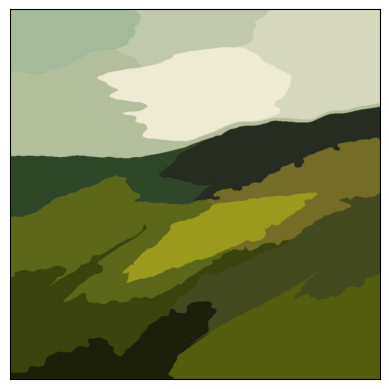

In [12]:
fig, ax = plt.subplots()
ax.tick_params(axis='both', length=0)
ax.set_xticklabels('')
ax.set_yticklabels('')
ax.imshow(X[0].numpy().transpose((1, 2, 0)))

In [7]:
y

tensor([[[[0.4784, 0.4784, 0.4824,  ..., 0.4863, 0.4824, 0.4824],
          [0.4784, 0.4784, 0.4824,  ..., 0.4902, 0.4863, 0.4824],
          [0.4784, 0.4784, 0.4824,  ..., 0.4902, 0.4902, 0.4863],
          ...,
          [0.0863, 0.0824, 0.0745,  ..., 0.4157, 0.4314, 0.4510],
          [0.0745, 0.0784, 0.0784,  ..., 0.4549, 0.4353, 0.4510],
          [0.0824, 0.0824, 0.0745,  ..., 0.4039, 0.5020, 0.4784]],

         [[0.5882, 0.5882, 0.5922,  ..., 0.5843, 0.5804, 0.5804],
          [0.5882, 0.5882, 0.5922,  ..., 0.5882, 0.5843, 0.5804],
          [0.5882, 0.5882, 0.5922,  ..., 0.5882, 0.5882, 0.5843],
          ...,
          [0.1059, 0.1020, 0.0902,  ..., 0.4667, 0.4824, 0.5020],
          [0.0941, 0.0980, 0.0941,  ..., 0.5020, 0.4824, 0.5020],
          [0.1059, 0.1020, 0.0902,  ..., 0.4549, 0.5529, 0.5294]],

         [[0.4980, 0.4980, 0.5020,  ..., 0.4980, 0.4941, 0.4941],
          [0.4980, 0.4980, 0.5020,  ..., 0.5020, 0.4980, 0.4941],
          [0.4980, 0.4980, 0.5020,  ..., 0

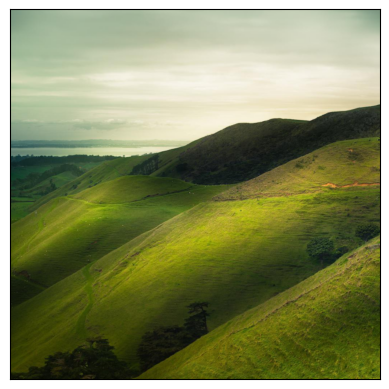

In [11]:
fig, ax = plt.subplots()
ax.tick_params(axis='both', length=0)
ax.set_xticklabels('')
ax.set_yticklabels('')
ax.imshow(y[0].numpy().transpose((1, 2, 0)))

In [ ]:
class Improver(torch.nn.Module):
    def __init__(self):
        super(Improver, self).__init__()
        self.fc1 = torch.nn.Linear(640 * 640, 4096)
        self.ac1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(4096, 2048)
        self.ac2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(2048, 640 * 640)

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        return x

model = Improver()
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)
epochs = []
loss_history=[]
correct_history=[]
for e in range(epochs):
    loss=0.0
    correct=0.0
    for input,labels in training_loader:
        inputs=input.view(input.shape[0],-1)
        outputs=model(inputs)
        loss1=loss(outputs,labels)
        optimizer.zero_grad()
        loss1.backward()
        optimizer.step()
        _,preds=torch.max(outputs,1)
        loss+=loss1.item()
        correct+=torch.sum(preds==labels.data)
    else:
        epoch_loss=loss/len(training_loader)
        epoch_acc=correct.float()/len(training_loader)
        loss_history.append(epoch_loss)
        correct_history.append(epoch_acc)
        print('training_loss:{:.4f},{:.4f}'.format(epoch_loss,epoch_acc.item()))